# DOCUMENT HEADER
AUTHOR:
LAST UPDATED:
Document Description FILL IN HERE


In [73]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from IPython.core.display import display, HTML
import matplotlib.ticker as mtick
from datetime import date, datetime
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib import lines    
from matplotlib.colors import is_color_like
import re

warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 550)
pd.set_option('display.max_columns', 550)

import snowflake.connector 
cnx = snowflake.connector.connect(
    user='nmittleman@toasttab.com',
    account='toast.us-east-1',
    authenticator='externalbrowser'
    )

%matplotlib inline

def QueryDWH(query, cnx, col=[]):
    cur = cnx.cursor()
    cur.execute(query)
    # If there is no col input, then get the columns from the return of the
    # snowflake query
    if not col:
        df = pd.DataFrame(cur.fetchall())
        if not df.empty:
            df.columns = [desc[0] for desc in cur.description]
    else:
        df = pd.DataFrame(cur.fetchall(), columns=col)
    
    for col in df.columns.tolist():
        success = False



        try:
            df[col] = df[col].astype(float)
            success = True
        except:
            pass
        
        # If it passed as a float - move to the next column
        if success:
            continue
            
        try:
            df[col] = pd.to_datetime(df[col], utc=True).dt.date
            success = True
        except:
            pass

        
    return df
QueryDWH("""USE DATABASE TOAST""", cnx)
QueryDWH("""USE WAREHOUSE TOAST_WH""", cnx)

,status
0,Statement executed successfully.


# Plotting Classes and Functions

In [74]:
def CheckKwArgs(kwargs, function):
    if kwargs.keys():
        acceptedArgs = list(function.__code__.co_varnames[:function.__code__.co_argcount])
        try:
            acceptedArgs.remove('self')
        except:
            pass
        raise Exception(f"Invalid Arguments Passed: Accepted Arguments are {acceptedArgs}")    

In [75]:
class PlotParams:
    # A Class that defines the plot characteristics
    # Plot characteristics are any attributes that define 
    # what type of plot, line colors, styles or smoothing
    
    def __init__(self, plotStyle = 'Line', fig=None, ax=None, grid=False, linestyle = '-', colorlist = None, k = 1, **kwargs):
        CheckKwArgs(kwargs, self.__init__)
        
        # Line Style
        if plotStyle in ['Line', 'Scatter']:
            self._plotStyle = plotStyle
        else:
            raise Exception("plotStyle must be one of: 'Line', 'Scatter'")
        
        # Grid
        if type(grid) == bool:
            self._grid = grid
        else:
            raise Exception("grid must be of Type Bool")
            
        # linestyle
        
        if (linestyle in lines.lineStyles.keys()) :
            self._linestyle = linestyle
        else:
            raise Exception(f"linestyle must be one of: {lines.lineStyles.keys()}")

        # Color List
        if colorlist is None:
             self._colorlist = ['r', 'b', 'g', 'c', 'orange', 'y', 'brown', 'grey', 'pink']
        # check to makesure the values are valid
        else:
            if type(colorlist) != list:
                raise Exception(f"colorList must be of Type List or else None")
            for color in colorlist:
                if type(color) == str:
                    colorTest = is_color_like(color) | self.is_hex_color(color)
                else:
                    colorTest = False
                if colorTest == False:
                    raise Exception(f"{color} Is Not a Valid Color")
            self._colorlist = colorlist

            
        # Fig and Ax
        if (fig is None) & (ax is None):
            self._fig, self._ax = plt.subplots(figsize=(20,10))
            plt.close(fig)
        elif ((fig is not None) + (ax is not None)) == 2:
            self._fig = fig
            self._ax = ax
        else:
            raise Exception("Need to Input both 'ax' and 'fig' parameters or neither, but cannot input one and not the other")            
            
            
        self._k = k
        
        self._colorCounter = 0

    def is_hex_color(self, input_string):
        
        HEX_COLOR_REGEX = r'^#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})$'        
        regexp = re.compile(HEX_COLOR_REGEX)
        if regexp.search(input_string):
            return True
        return False
    
    def reset_color_counter(self):
        self._colorCounter = 0
        
    def increment_color_counter(self):
        self._colorCounter += 1  
        self._colorCounter = self._colorCounter % len(self._colorlist)
        
    def get_next_color(self):
        next_color = self._colorlist[self._colorCounter]
        self.increment_color_counter()
        return next_color
        
class AxisParams:
    # Definition of parameters of a plot's axis
    def __init__(self, title = '', axisFormat = None, rotation = 0, spacing = 'smart', fontsize = 14, color = 'k', **kwargs):
        CheckKwArgs(kwargs, self.__init__)
        
        self._title = title
        self._format = axisFormat
        self._rotation = rotation
        self._spacing = spacing
        self._fontsize = fontsize
        self._color = color
        
class TitleParams:
    # Definition of parameters of a plot's title
    def __init__(self, title = '', fontsize = 14, color='k', **kwargs):
        CheckKwArgs(kwargs, self.__init__)
        self._title = title
        self._fontsize = fontsize
        self._color = color

        
class LegendParams:
    # Definition of parameters of a plot's legend
    def __init__(self, show = True, location = 'best', size=30, **kwargs):
        CheckKwArgs(kwargs, self.__init__)
        
        self._show = show # A boolean. True means display legend, false does not
        self._location = location # The location of the legend
        self._size = size # Size of the legend text


In [76]:
def GetSmoothedSeries(index, data, k ):
        if k == 1:
            return index, data
            
        else:
            xNew = np.linspace(index.min(), index.max(), len(index)*20 - 19)
        if len(index) < 4:
            return xNew, yNew

        tmpSpl = make_interp_spline(index, data, k=k)

        yNew = tmpSpl(xNew)    
        
        return xNew, yNew

In [77]:
def FormatPlot(ax, xAxisParams, yAxisParams, titleParams, maxAxis, xAxis):
                
    xAxisList = maxAxis[xAxis]
    xAxisInd = maxAxis['index']
    
    if xAxisParams._format == 'i':
        xAxisList = xAxisList.astype(int)
    elif xAxisParams._format:
        xAxisList = pd.to_datetime(xAxisList).dt.strftime(xAxisParams._format)           
    
    if xAxisParams._spacing == 'smart':
        spacing = int(np.ceil(len(xAxisList.to_numpy()) / 6))
    else:
        spacing = xAxisParams._spacing
    
    
    ax.set_xticks(xAxisInd.to_numpy()[::spacing])
    ax.set_xticklabels(xAxisList.to_numpy()[::spacing])

    if yAxisParams._format == '%':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    elif yAxisParams._format == '$':
        ax.yaxis.set_major_formatter('${x:1.0f}')   
    elif yAxisParams._format == '2$':
        ax.yaxis.set_major_formatter('${x:1.2f}') 

    ax.tick_params(axis='x', labelsize=24, rotation=xAxisParams._rotation, colors=xAxisParams._color)
    ax.tick_params(axis='y', labelsize=24, colors=yAxisParams._color)

    ax.set_xlabel(xAxisParams._title, fontsize=xAxisParams._fontsize, color=xAxisParams._color)
    ax.set_ylabel(yAxisParams._title, fontsize=yAxisParams._fontsize, color=yAxisParams._color)
    ax.set_title(titleParams._title, fontsize=titleParams._fontsize, color=titleParams._color)    

In [78]:
def GetPlotStyleParameters(col, key, numGroups, numCols, plotParams,  colorCounter):
    if numGroups == 1:
        label = f'{col}'
    elif numCols == 1:
        label = f'{key}'
    else:
        label = f'{key} - {col}'

    color = plotParams.get_next_color()

    if key == 'Total':
        color = 'k'

    if key == 'Total':
        linestyle = '--'
    else:
        linestyle = plotParams._linestyle                



    return color, linestyle, label, colorCounter

In [102]:
def PlotSmoothLine(df, xAxis, colList, 
                   group = None, 
                   plotParams = None,
                   xAxisParams = None,
                   yAxisParams = None,
                   legendParams = None,
                   titleParams = None,
                   smoothing = True, 
                   savefig = None, showPlot=True, verbose = False):
    
    # Initializing Inputs
    if not plotParams:
        plotParams = PlotParams()
    fig = plotParams._fig
    ax = plotParams._ax
    
    if not titleParams:
        titleParams = TitleParams()
    
    if not xAxisParams:
        xAxisParams = AxisParams()
        
    if not yAxisParams:
        yAxisParams = AxisParams()
    
    if not legendParams:
        legendParams = LegendParams()
   
    deleteGroup = False
    if group is None:
        group = '__temp_group'
        df[group] = 'A'
        deleteGroup = True
    
    # If the column input is a column name - turn it into a list
    if type(colList) == str:
        colList = [colList]
    numCols = len(colList)    
    numGroups = df[group].nunique()
    
    # Create a master axis which has all of the axis points for each grouping
    maxAxis = pd.DataFrame(df[xAxis].unique(), columns = [xAxis])
    maxAxis.reset_index(inplace=True)
    
    colorCounter = 0
    grpbyObj = df.groupby([group])
    
    # Iterate through each col in the col list and each group in the grouping and plot that
    for col in colList:
        for key, grp in grpbyObj:
            
            # Ensure that the axes always align - this is done by merging the data to the maxAxis
            # any nulls are forward fills and any leading nulls are zeroed

            firstAxisVal = grp[xAxis].min()
            lastAxisVal = grp[xAxis].max()

            grp = maxAxis.merge(grp, how='left')
            grp[group] = key
            grp[col].fillna(method='ffill', inplace=True)
            grp[col].fillna(0, inplace=True)
            grp = grp.reset_index(drop=True).reset_index()
            
            firstInd = grp[grp[xAxis] == firstAxisVal]['index'].min()
            lastInd = grp[grp[xAxis] == lastAxisVal]['index'].max()
            if verbose:
                display(firstAxisVal)
                display(lastAxisVal)                
                display(firstInd)
                display(lastInd)
                display(grp)


            # if k = 1 (no smoothing, then the axes and data points remain as they are)
            if plotParams._k == 1:
                xNew = grp['index']
                yNew = grp[col]
            else:
                # if there is smoothing - create the new smoothed data points
                xNew, yNew = GetSmoothedSeries(grp['index'], grp[col], plotParams._k )
            
            try:
                firstIndNew = np.where(xNew == firstInd)[0][0]
            except:
                firstIndNew = 0
                
            try:
                lastIndNew = np.where(xNew == lastInd)[0][-1]
            except:
                lastIndNew = len(xNew)
                
            if verbose:
                display(firstIndNew)
                display(lastIndNew)                
               
            yNew[0:(firstIndNew)] = np.nan
            yNew[lastIndNew:-1] = np.nan


                
                
            # Get the plot / line attributes
            color, linestyle, label, colorCounter = GetPlotStyleParameters(col, key, numGroups, numCols, plotParams, colorCounter)
            
            #
            if plotParams._plotStyle == 'Line':
                ax.plot(xNew, yNew, label = label, c=color, linestyle=linestyle)
            elif plotParams._plotStyle == 'Scatter':     
                ax.scatter(xNew, yNew, label = label, c=color)

    FormatPlot(ax, xAxisParams, yAxisParams, titleParams, maxAxis,xAxis)

    if plotParams._grid:
        ax.grid()

    if legendParams._show:
        ax.legend(loc=legendParams._location, prop={'size': legendParams._size})

    if savefig:
        plt.savefig(f'{savefig}.png', bbox_inches='tight')

    if showPlot:
        display(fig)
        
    if deleteGroup:
        df.drop([group], axis=1, inplace=True, errors='ignore')

    return fig, ax

# Data Ingestions

In [ ]:
query = """
        SELECT a.customer_id
             , a.firstdayofmonth
             , a.msa_name
             , a.region
             , a.parent_market_segment
             , a.restaurant_type
             , a.restaurant_service_model
             , IFF(c.ecommerce_order_reference_id IS NOT NULL, True, False) AS ecomm
             , c.close_sales_rep_id AS rep_id             
             , a.pos_go_live_this_month
             , b.opportunity_close_date
             , b.pos_first_order_date
             , a.live_arr
             , a.live_payments_arr
             , a.live_saas_arr
             , (live_guest_saas_arr) guest
             , (live_core_arr) core 
             , (live_ec_arr) ec
             , (live_xtrachef_arr) xc
             , a.gpv
             , a.margin
             , a.gpv_transactions
             , SUM(IFF( dateadd('Month', 0, b.pos_first_order_date)< a.firstdayofmonth, a.gpv, 0)) OVER (PARTITION BY a.customer_id ORDER BY a.firstdayofmonth rows between 11 preceding and current row) AS gpv_last_n_months
             , COUNT(IFF(dateadd('Month', 0, b.pos_first_order_date) < a.firstdayofmonth, a.firstdayofmonth, null)) OVER (PARTITION BY a.customer_id ORDER BY a.firstdayofmonth rows between 11 preceding and current row) AS last_months
             , DIV0(gpv_last_n_months , last_months) * 12 AS annualized_gpv
             , a.gmv
             , a.gmv_transactions
             , a.distinct_module_count
             , IFF(a.live_ec_arr > 0, 1, 0) AS EC
             , a.live_oo_count
             , a.live_gc_count
             , a.live_loyalty_count
             , a.live_tto_count
             , a.live_marketing_count
             , a.live_tds_count
             , a.live_opt_count
             , a.live_dd_count
             , a.live_ue_count
             , a.live_gh_count
             , a.live_hh_saas_count
             , a.live_kiosk_saas_count
             , a.live_kds_saas_count
             , a.live_api_saas_count
             , a.live_mlm_saas_count
             , a.live_core_saas_count
        FROM analytics_core_arr.monthly_book_of_business a
        INNER JOIN analytics_core.customer b
        ON a.customer_id = b.customer_id
        INNER JOIN gtm.opportunity c
        ON b.salesforce_opportunityid = c.salesforce_opportunityid        
        WHERE a.pos_status = 'Live'
        AND firstdayofmonth < DATE_TRUNC('Month', CURRENT_DATE)
        AND b.pos_first_order_Date IS NOT NULL
        """
monthlyCustBoB = QueryDWH(query, cnx, ['Customer Id', 'Month', 'MSA', 'Region', 'Segment', 'Type', 'FSR/QSR', 'E-Comm', 'Rep Id','Go-Live This Month', 'Close Date', 'FOD', 
                                    'Live ARR', 'Live Payments ARR', 'Live SaaS ARR', 'Guest SaaS ARR', 'Commerce SaaS ARR', 'EC SaaS ARR', 'XC SaaS ARR','GPV', 'Margin','GPV Tx', 'GPV Last N Months', 'Last N Months', 'Annualized GPV', 'GMV', 'GMV Tx',
                                    'Module Count', 'EC','OO', 'GC', 'Loyalty', 'TTO', 'Marketing', 'TDS', 'OPT', 'DD', 'UE', 'GH',
                                    'HH', 'Kiosk', 'KDS', 'API', 'MLM', 'Core'])
monthlyCustBoB['Close Month'] = pd.to_datetime(monthlyCustBoB['Close Date'].astype("datetime64[M]")).dt.date
monthlyCustBoB['Close Quarter'] = pd.to_datetime(monthlyCustBoB['Close Date']).dt.to_period("Q").dt.start_time
monthlyCustBoB['Close Quarter'] = pd.to_datetime(monthlyCustBoB['Close Quarter']).dt.date
monthlyCustBoB['FOQ'] = pd.to_datetime(monthlyCustBoB['FOD']).dt.to_period("Q").dt.start_time
monthlyCustBoB['FOQ'] = pd.to_datetime(monthlyCustBoB['FOQ']).dt.date

monthlyCustBoB['E-Comm'] = monthlyCustBoB['E-Comm'].astype(bool)

monthlyCustBoB['FSR/QSR'] = np.where(monthlyCustBoB['FSR/QSR'].isin(['FSR', 'QSR']), monthlyCustBoB['FSR/QSR'], 'QSR')
monthlyCustBoB['FSR/QSR/E-Comm'] = np.where(monthlyCustBoB['E-Comm'], 'E-Comm', monthlyCustBoB['FSR/QSR'])


In [391]:
query = """
        SELECT DATE_TRUNC('Month', dt) AS month
             , customer_id
             , SUM(saas_price) * 12 AS ec_monthly_arr
        FROM analytics_core_arr.saas_daily_status
        WHERE saas_status = 'Live'
        AND product_name IN ('Payroll Integration', 'Toast Tips Manager Integration', 'Scheduling Pro')
        GROUP BY 1,2
    
        """
monthlyCustEC = QueryDWH(query, cnx, ['Month', 'Customer Id', 'EC Monthly ARR'])

In [ ]:
monthlyCust = monthlyCustBoB.merge(monthlyCustEC, how='left')
monthlyCust['EC Monthly ARR'].fillna(0, inplace=True)
monthlyCust['EC Usage ARR'] = monthlyCust['EC SaaS ARR'] - monthlyCust['EC Monthly ARR']

In [126]:
query = """
        SELECT *
        FROM toast_nmittleman_dev.public.booking
        """
bookings = QueryDWH(query, cnx)

# Data Exploration

## GPV Per Location of Bookings

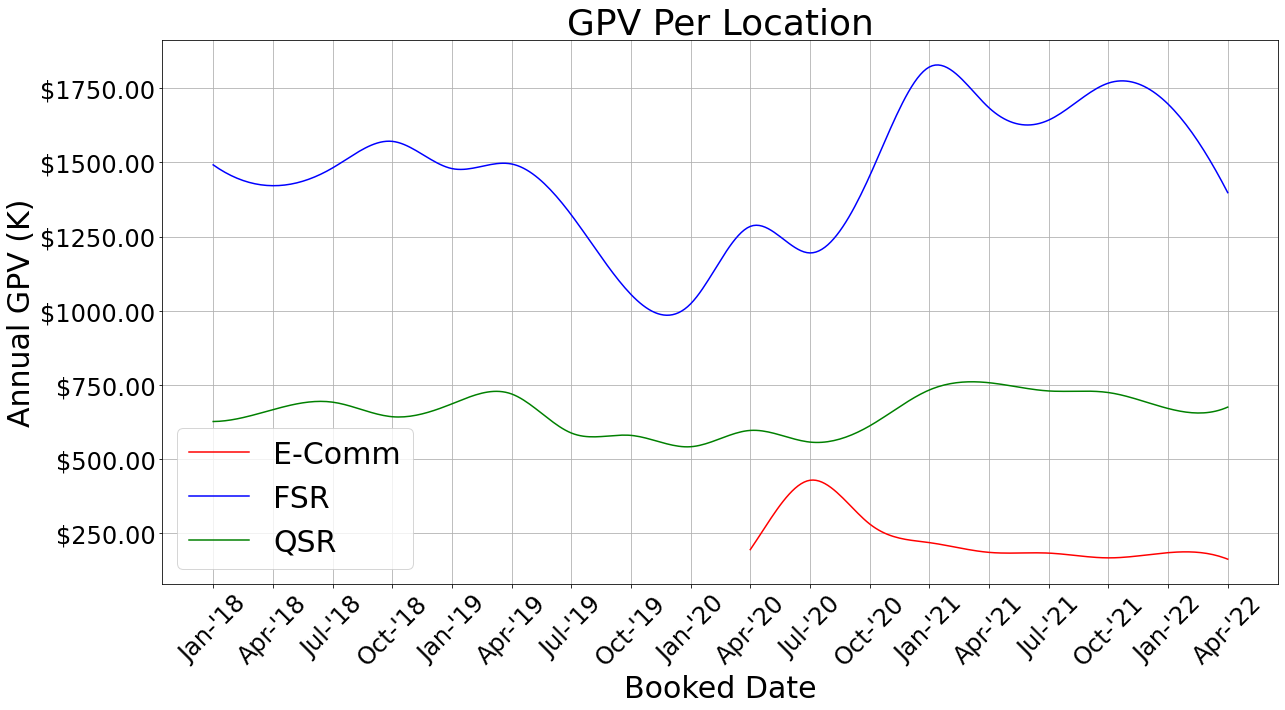

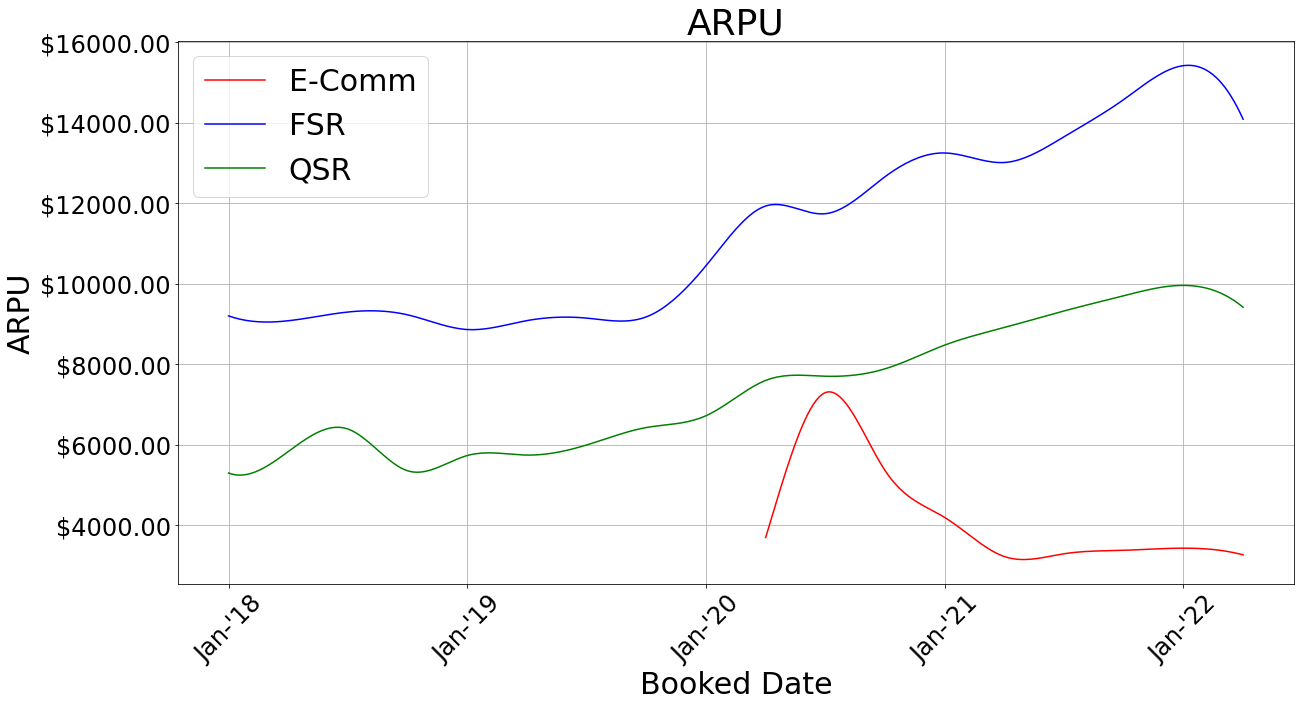

In [199]:

bookingCust = monthlyCust[(monthlyCust['Last N Months'] == 3) & (monthlyCust['GPV'] > 0)].sort_values('Month').drop_duplicates(['Customer Id'], keep='last')
dateGroup = 'Close Quarter'
grouping = 'FSR/QSR/E-Comm'


tmp = bookingCust.groupby([dateGroup, grouping]).agg({'Customer Id': 'nunique', 'Annualized GPV':'sum', 'Live ARR':'sum'}).reset_index().rename(columns = {'Customer Id': 'Locations'})
tmp['Avg GPV'] = np.round((tmp['Annualized GPV'] / tmp['Locations']) / 1E3,2)
tmp['ARPU'] = tmp['Live ARR'] / tmp['Locations']
tmp = tmp[(tmp[dateGroup] >= date(2018,1,1)) & (tmp[dateGroup] < date(2022,7,1))]
tmp['Percent of Locations'] = np.round(100 * tmp['Locations'] / tmp.groupby([dateGroup])['Locations'].transform('sum'), 2)



# Booked Annual GPV
xAxisParams = AxisParams(spacing = 1, rotation = 45, axisFormat = "%b-'%y", title='Booked Date', fontsize = 30)
yAxisParams = AxisParams(axisFormat = "2$", title='Annual GPV (K)', fontsize = 30)
linePlot = PlotParams(plotStyle = 'Line', grid=True, k=3)
titleParams = TitleParams(title='GPV Per Location', fontsize=36)
legend = LegendParams(show=True)
fig, ax  = PlotSmoothLine(tmp, dateGroup,  ['Avg GPV'], group=grouping,  
                  plotParams = linePlot,
                  xAxisParams = xAxisParams,
                  yAxisParams = yAxisParams,
                  titleParams = titleParams,
                  legendParams = legend,
                   
                   smoothing = True, showPlot = True,
                   savefig =None, verbose=False)

# Booked ARPU
xAxisParams = AxisParams(spacing = 4, rotation = 45, axisFormat = "%b-'%y", title='Booked Date', fontsize = 30)
yAxisParams = AxisParams(axisFormat = "2$", title='ARPU', fontsize = 30)
linePlot = PlotParams(plotStyle = 'Line', grid=True, k=3)
titleParams = TitleParams(title='ARPU', fontsize=36)
legend = LegendParams(show=True)
fig, ax  = PlotSmoothLine(tmp, dateGroup,  ['ARPU'], group=grouping,  
                  plotParams = linePlot,
                  xAxisParams = xAxisParams,
                  yAxisParams = yAxisParams,
                  titleParams = titleParams,
                  legendParams = legend,
                   
                   smoothing = True, showPlot = True,
                   savefig =None, verbose=False)

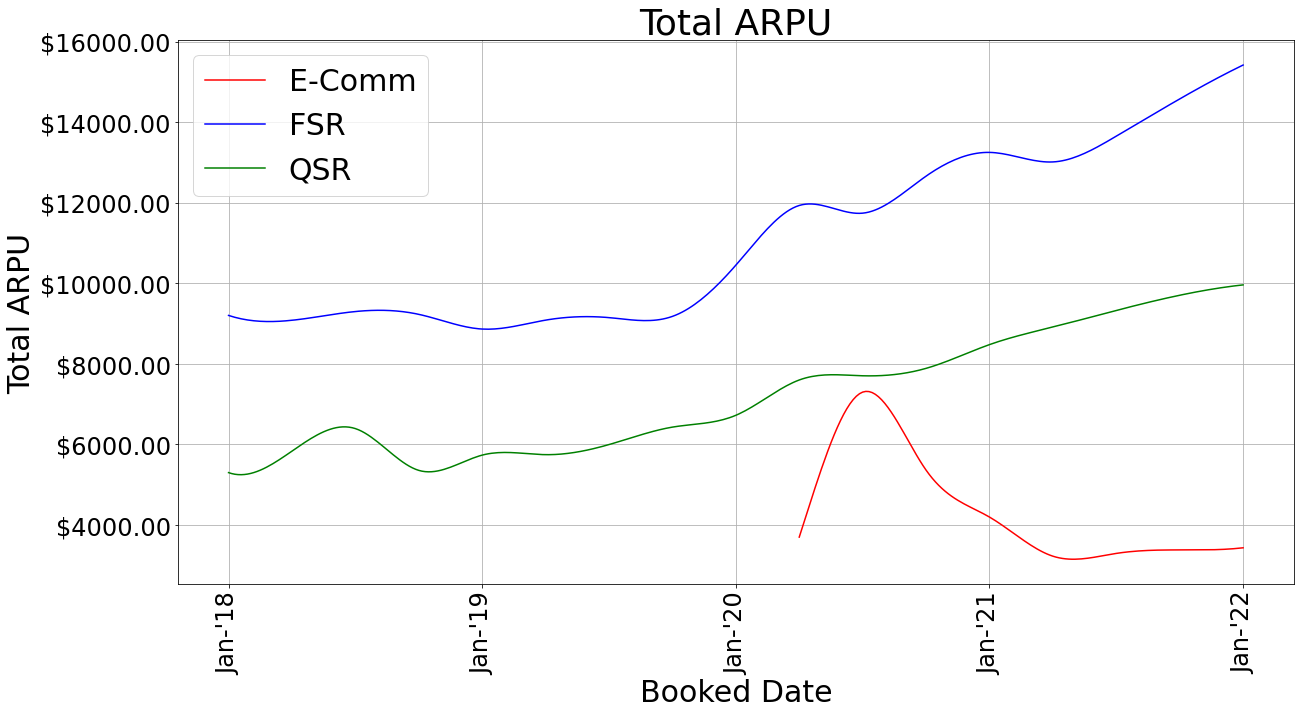

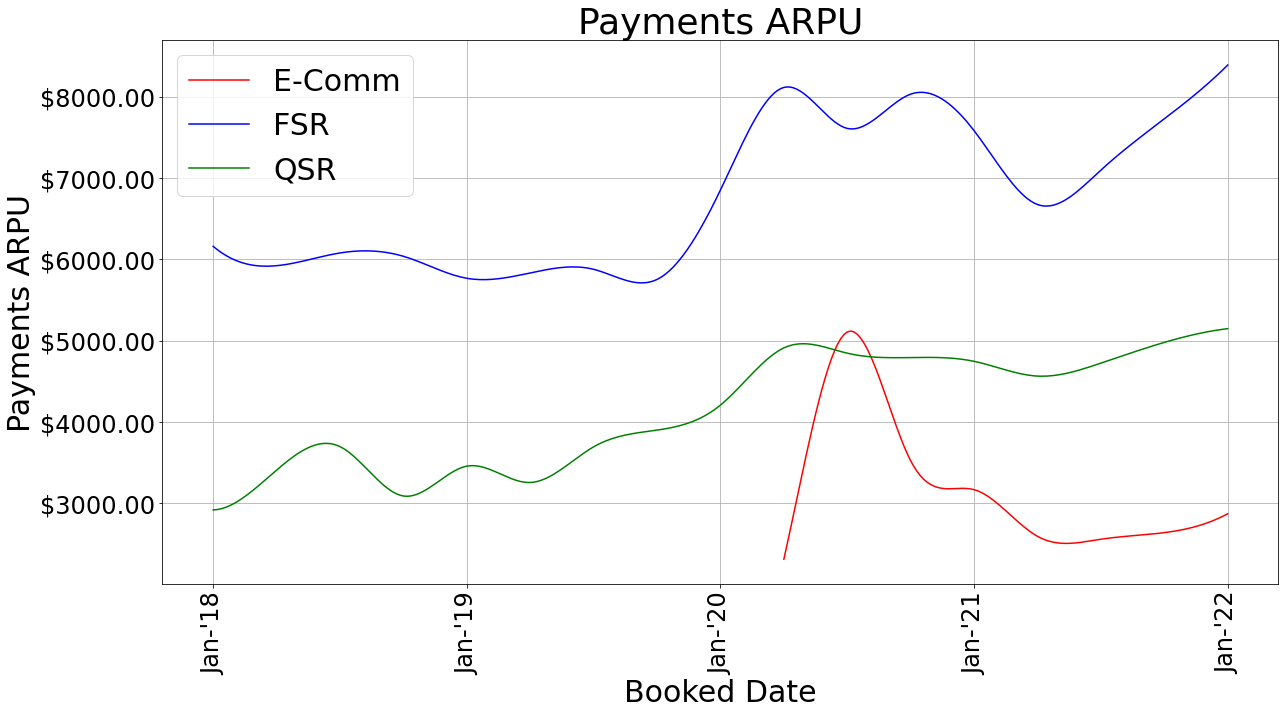

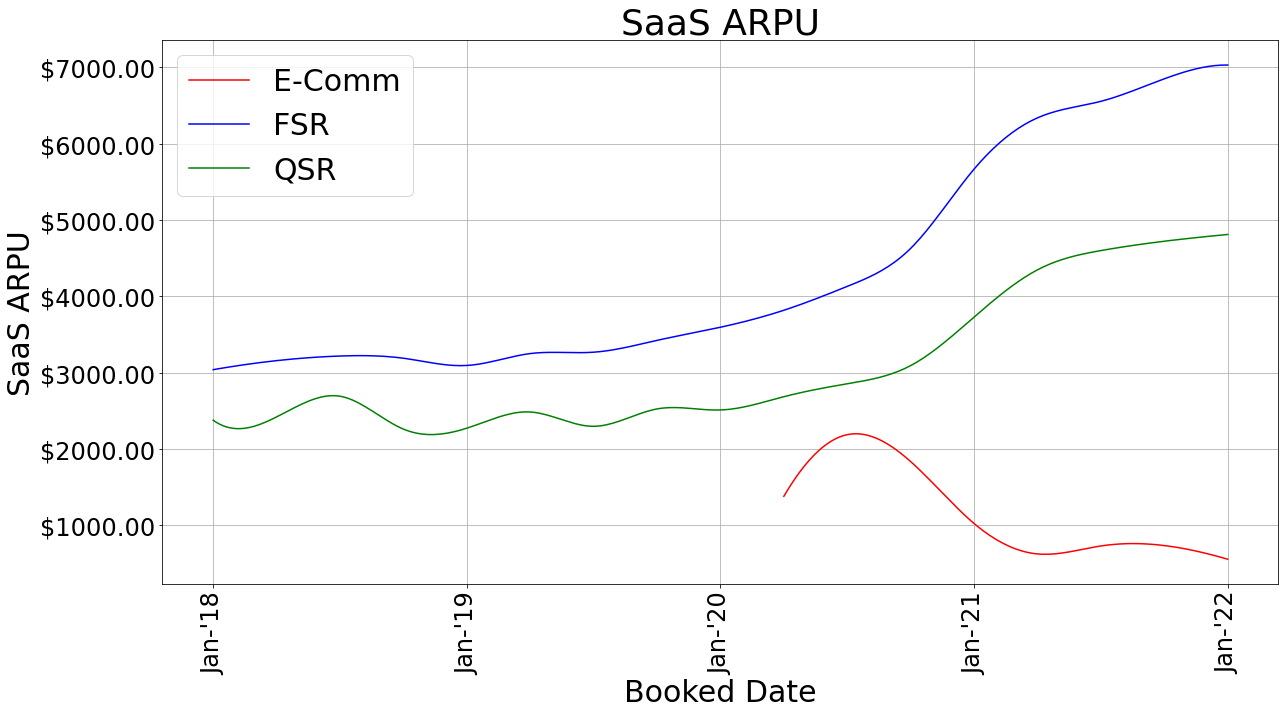

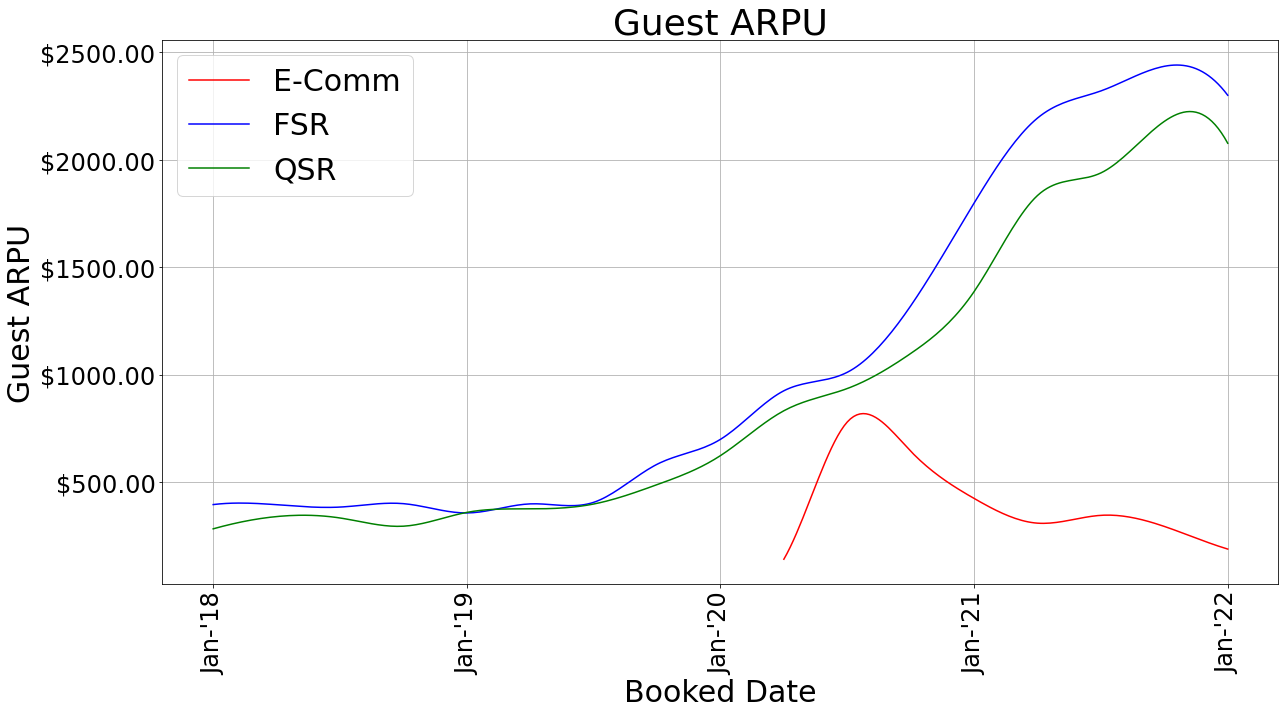

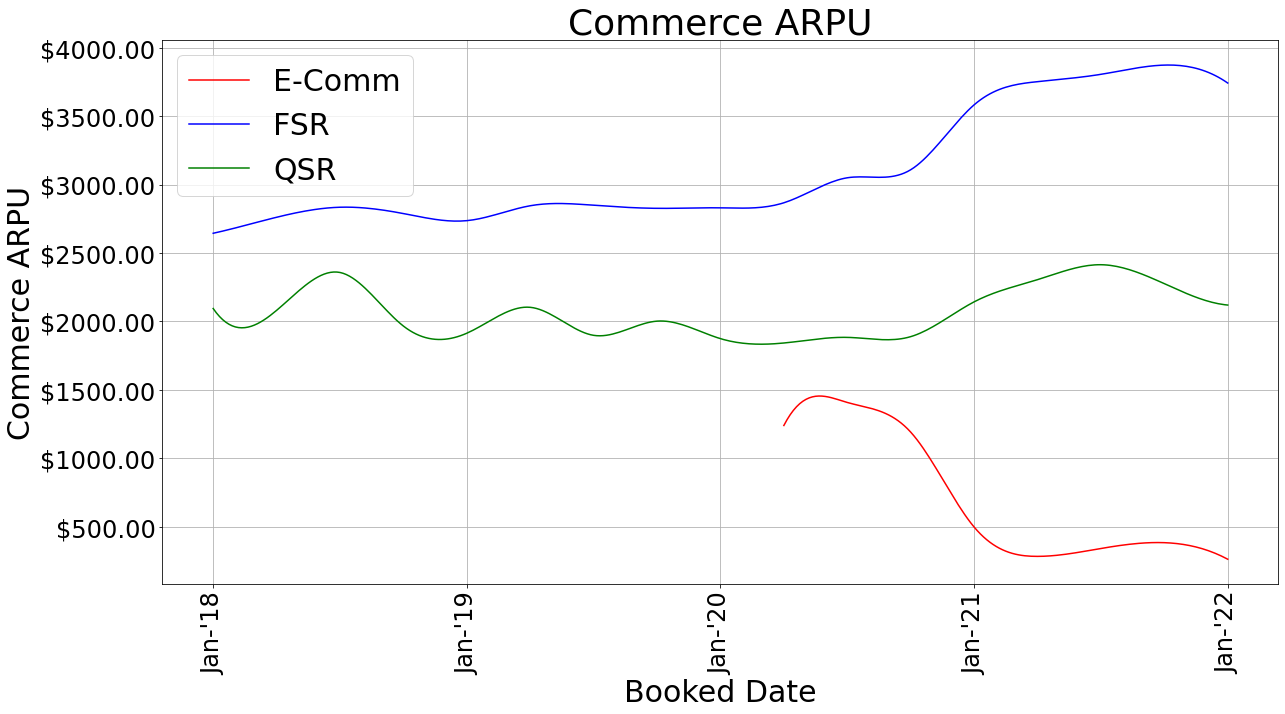

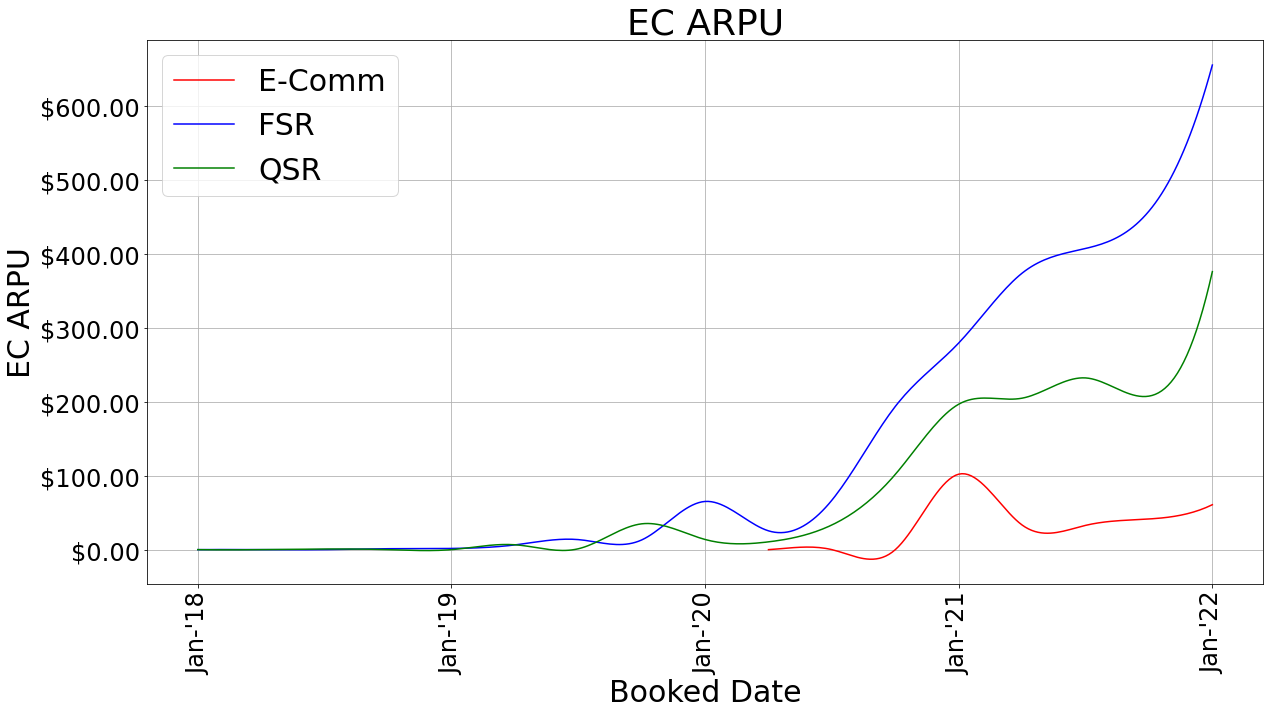

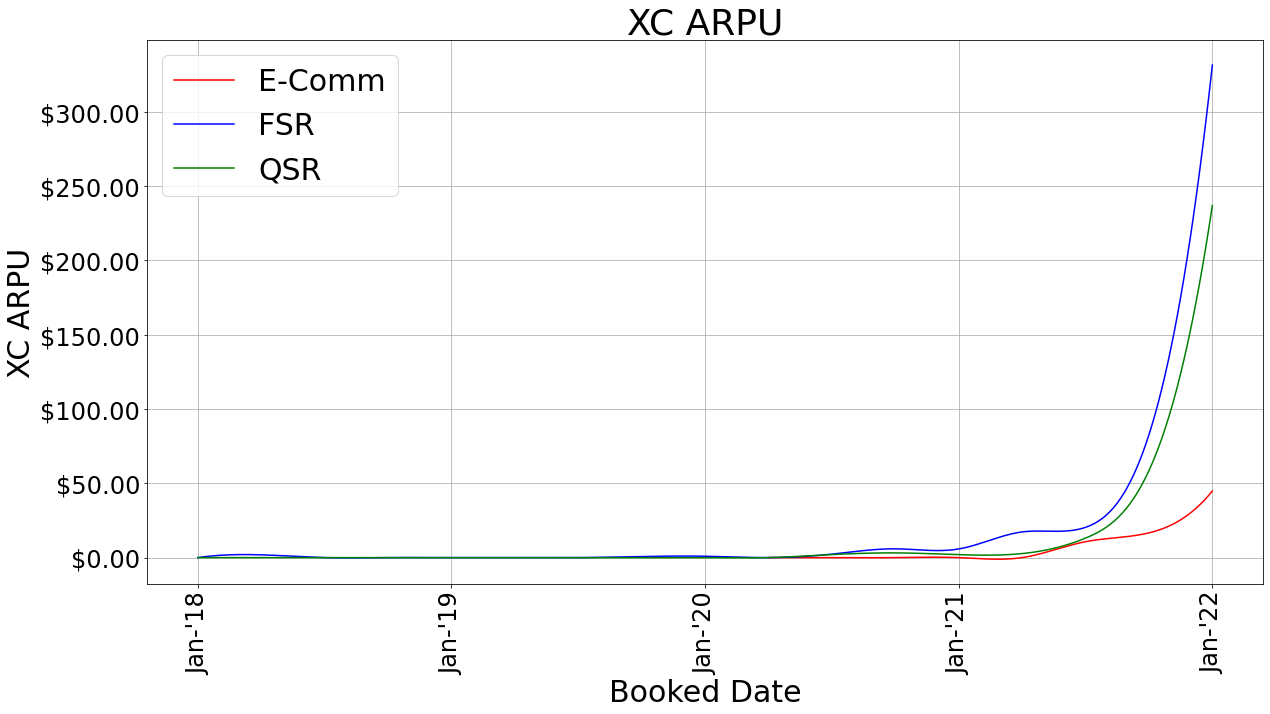

In [198]:

bookingCust = monthlyCust[(monthlyCust['Last N Months'] == 3) & (monthlyCust['GPV'] > 0)].sort_values('Month').drop_duplicates(['Customer Id'], keep='last')

dateGroup = 'Close Quarter'
grouping = 'FSR/QSR/E-Comm'


tmp = bookingCust.groupby([dateGroup, grouping]).agg({'Customer Id': 'nunique', 'Live ARR': 'sum','Live Payments ARR': 'sum','Live SaaS ARR':'sum', 'Guest SaaS ARR':'sum', 'Commerce SaaS ARR':'sum', 'EC SaaS ARR':'sum', 'XC SaaS ARR':'sum'}).reset_index().rename(columns = {'Customer Id': 'Locations'})
tmp['Total ARPU'] = tmp['Live ARR'] / tmp['Locations']
tmp['Payments ARPU'] = tmp['Live Payments ARR'] / tmp['Locations']
tmp['SaaS ARPU'] = tmp['Live SaaS ARR'] / tmp['Locations']
tmp['Guest ARPU'] = tmp['Guest SaaS ARR'] / tmp['Locations']
tmp['Commerce ARPU'] = tmp['Commerce SaaS ARR'] / tmp['Locations']
tmp['EC ARPU'] = tmp['EC SaaS ARR'] / tmp['Locations']
tmp['XC ARPU'] = tmp['XC SaaS ARR'] / tmp['Locations']
tmp = tmp[(tmp[dateGroup] >= date(2018,1,1)) & (tmp[dateGroup] < date(2022,7,1))]
tmp['Percent of Locations'] = np.round(100 * tmp['Locations'] / tmp.groupby([dateGroup])['Locations'].transform('sum'), 2)
# tmp = tmp[tmp['Locations'] > 50]

for col in ['Total ARPU', 'Payments ARPU','SaaS ARPU', 'Guest ARPU', 'Commerce ARPU', 'EC ARPU', 'XC ARPU']:
    # Booked SaaS ARPU
    xAxisParams = AxisParams(spacing = 4, rotation = 90, axisFormat = "%b-'%y", title='Booked Date', fontsize = 30)
    yAxisParams = AxisParams(axisFormat = "2$", title=col, fontsize = 30)
    linePlot = PlotParams(plotStyle = 'Line', grid=True, k=3)
    titleParams = TitleParams(title=col, fontsize=36)
    legend = LegendParams(show=True)
    fig, ax  = PlotSmoothLine(tmp, dateGroup,  [col], group=grouping,  
                      plotParams = linePlot,
                      xAxisParams = xAxisParams,
                      yAxisParams = yAxisParams,
                      titleParams = titleParams,
                      legendParams = legend,

                       smoothing = True, showPlot = True,
                       savefig =None, verbose=False)

# By Live Month

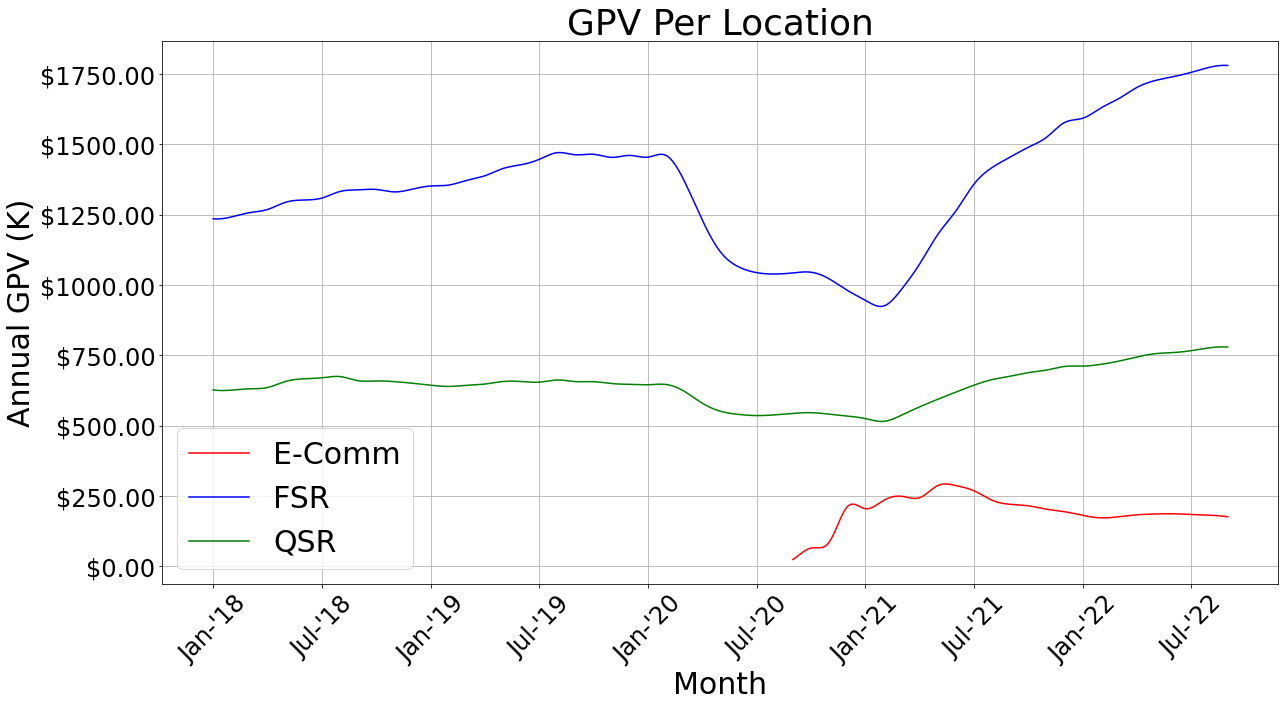

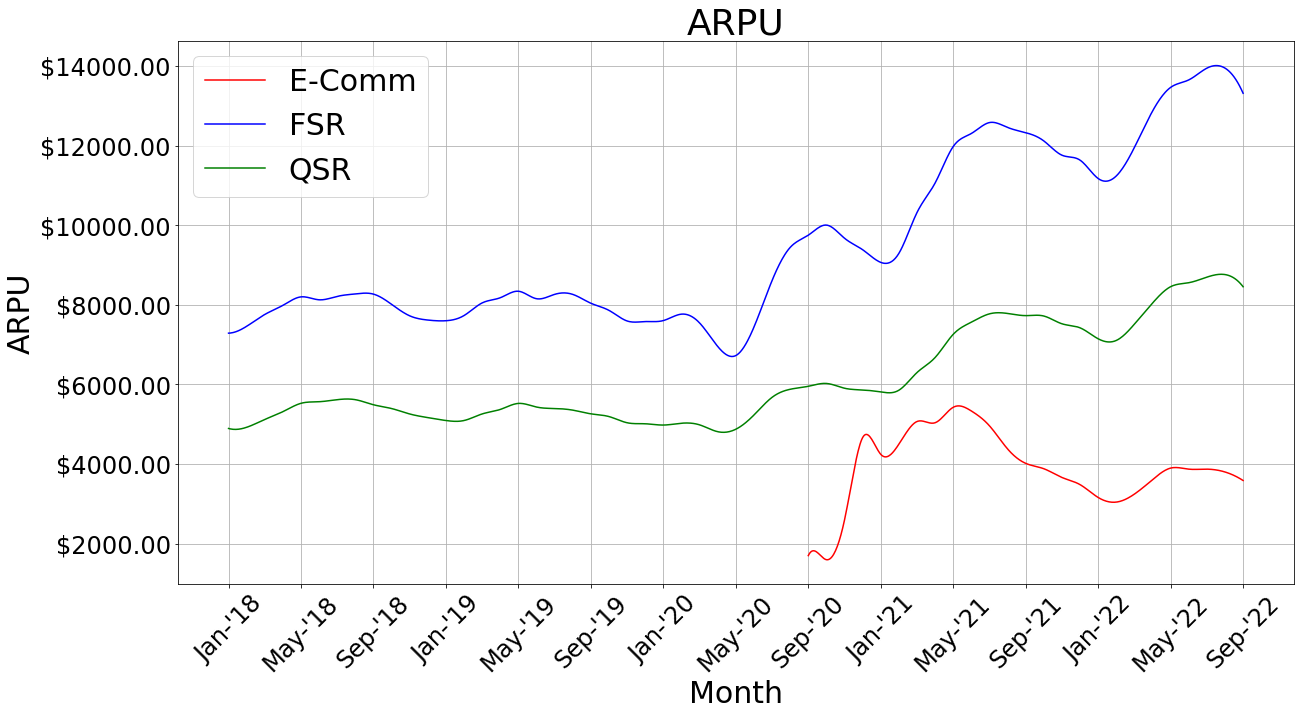

In [192]:
dateGroup = 'Month'
grouping = 'FSR/QSR/E-Comm'


tmp = monthlyCust[(monthlyCust['Last N Months'] >= 3)].groupby([dateGroup, grouping]).agg({'Customer Id': 'nunique', 'Annualized GPV':'sum', 'Live ARR':'sum'}).reset_index().rename(columns = {'Customer Id': 'Locations'})
tmp['Avg GPV'] = np.round((tmp['Annualized GPV'] / tmp['Locations']) / 1E3,2)
tmp['ARPU'] = tmp['Live ARR'] / tmp['Locations']
tmp = tmp[(tmp[dateGroup] >= date(2018,1,1)) & (tmp[dateGroup] < date(2022,10,1))]
tmp['Percent of Locations'] = np.round(100 * tmp['Locations'] / tmp.groupby([dateGroup])['Locations'].transform('sum'), 2)


# Display GPV Per Customer
xAxisParams = AxisParams(spacing = 6, rotation = 45, axisFormat = "%b-'%y", title='Month', fontsize = 30)
yAxisParams = AxisParams(axisFormat = "2$", title='Annual GPV (K)', fontsize = 30)
linePlot = PlotParams(plotStyle = 'Line', grid=True, k=3)
titleParams = TitleParams(title='GPV Per Location', fontsize=36)
legend = LegendParams(show=True)
fig, ax  = PlotSmoothLine(tmp, dateGroup,  ['Avg GPV'], group=grouping,  
                  plotParams = linePlot,
                  xAxisParams = xAxisParams,
                  yAxisParams = yAxisParams,
                  titleParams = titleParams,
                  legendParams = legend,
                   
                   smoothing = True, showPlot = True,
                   savefig =None, verbose=False)

# Display ARPU

xAxisParams = AxisParams(spacing = 4, rotation = 45, axisFormat = "%b-'%y", title='Month', fontsize = 30)
yAxisParams = AxisParams(axisFormat = "2$", title='ARPU', fontsize = 30)
linePlot = PlotParams(plotStyle = 'Line', grid=True, k=3)
titleParams = TitleParams(title='ARPU', fontsize=36)
legend = LegendParams(show=True)
fig, ax  = PlotSmoothLine(tmp, dateGroup,  ['ARPU'], group=grouping,  
                  plotParams = linePlot,
                  xAxisParams = xAxisParams,
                  yAxisParams = yAxisParams,
                  titleParams = titleParams,
                  legendParams = legend,
                   
                   smoothing = True, showPlot = True,
                   savefig =None, verbose=False)




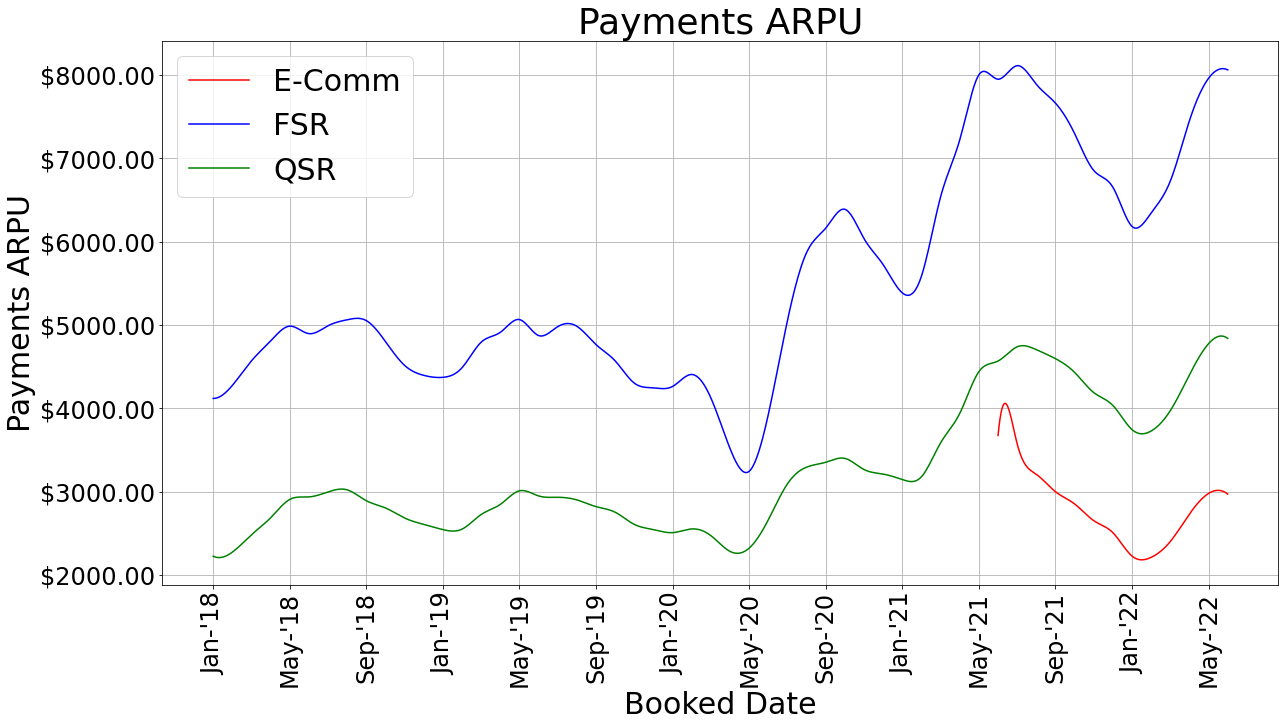

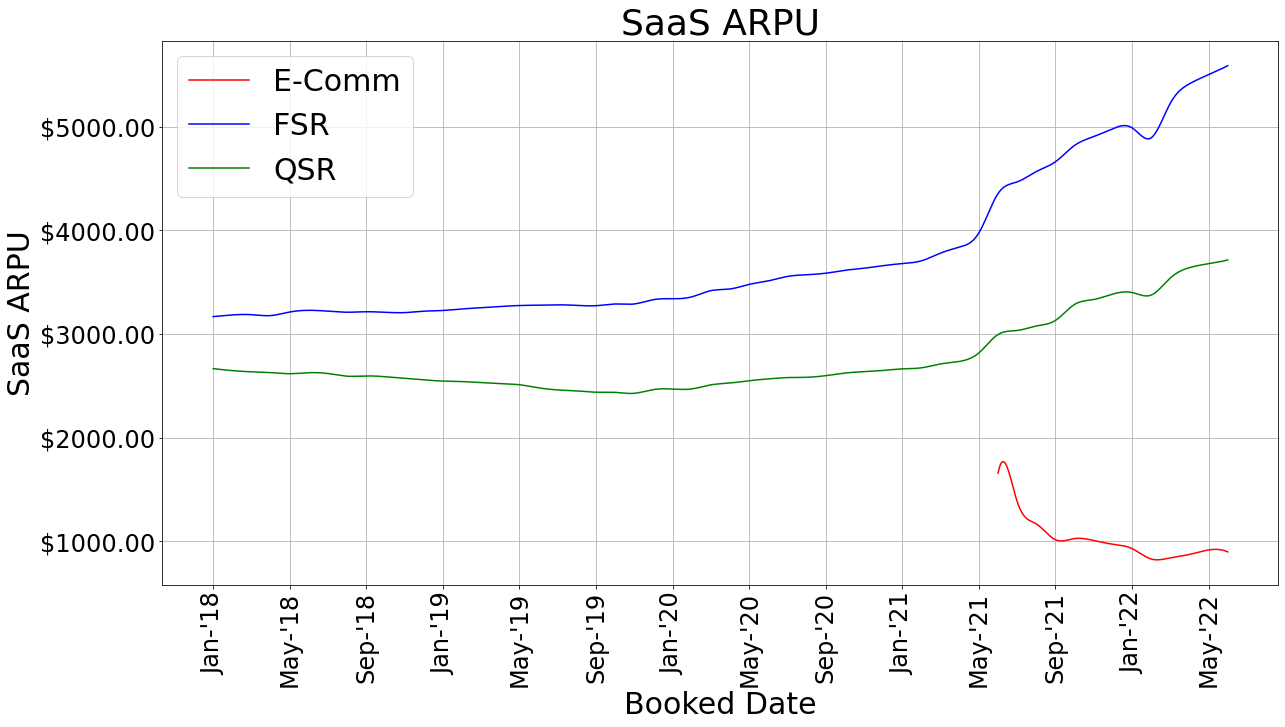

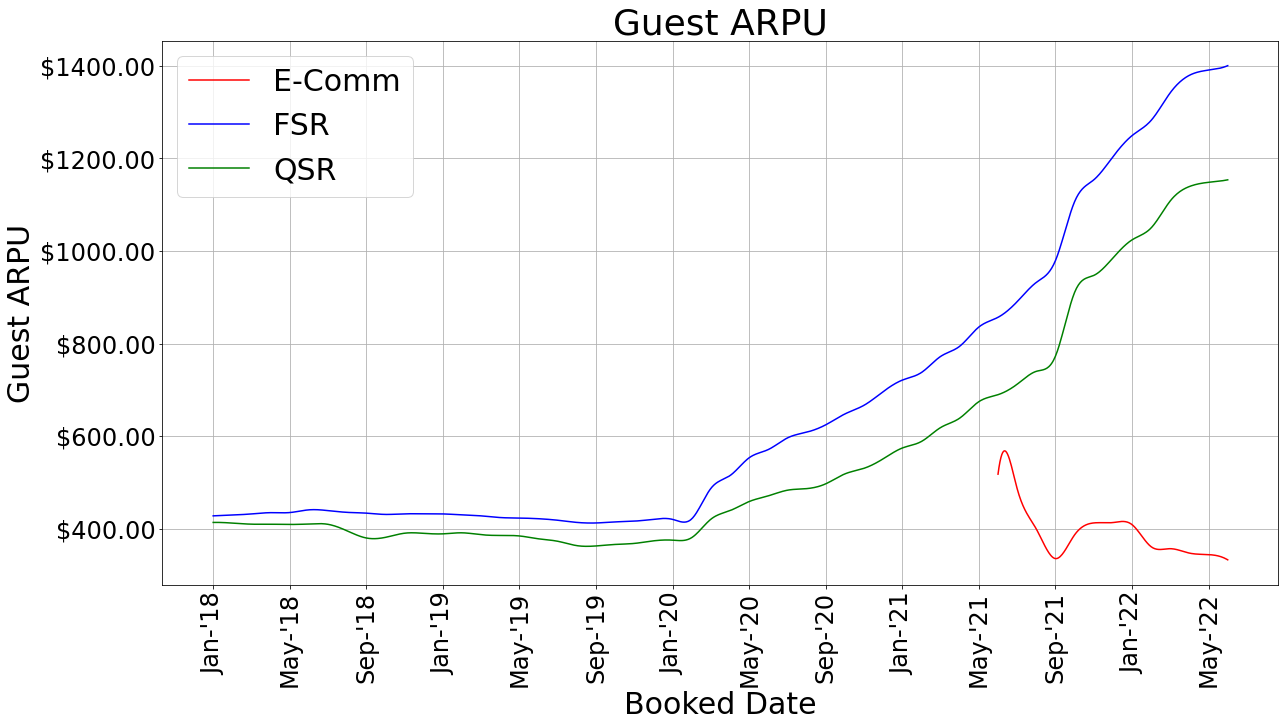

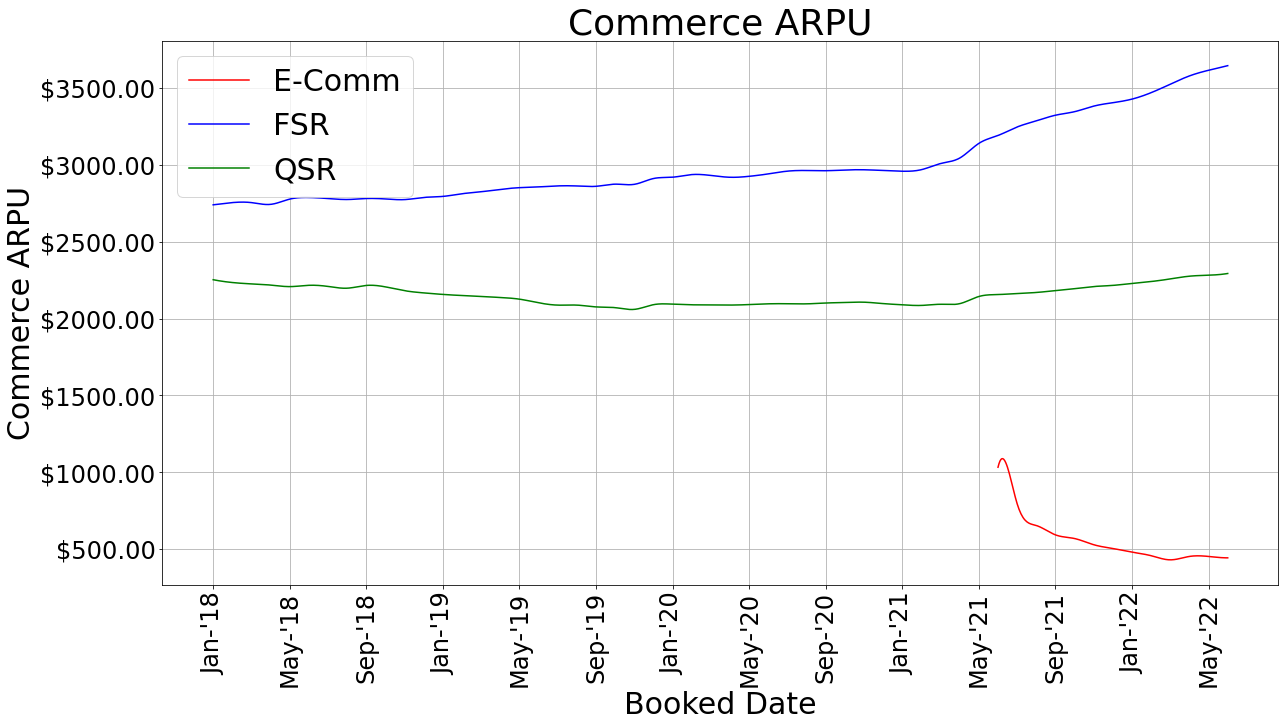

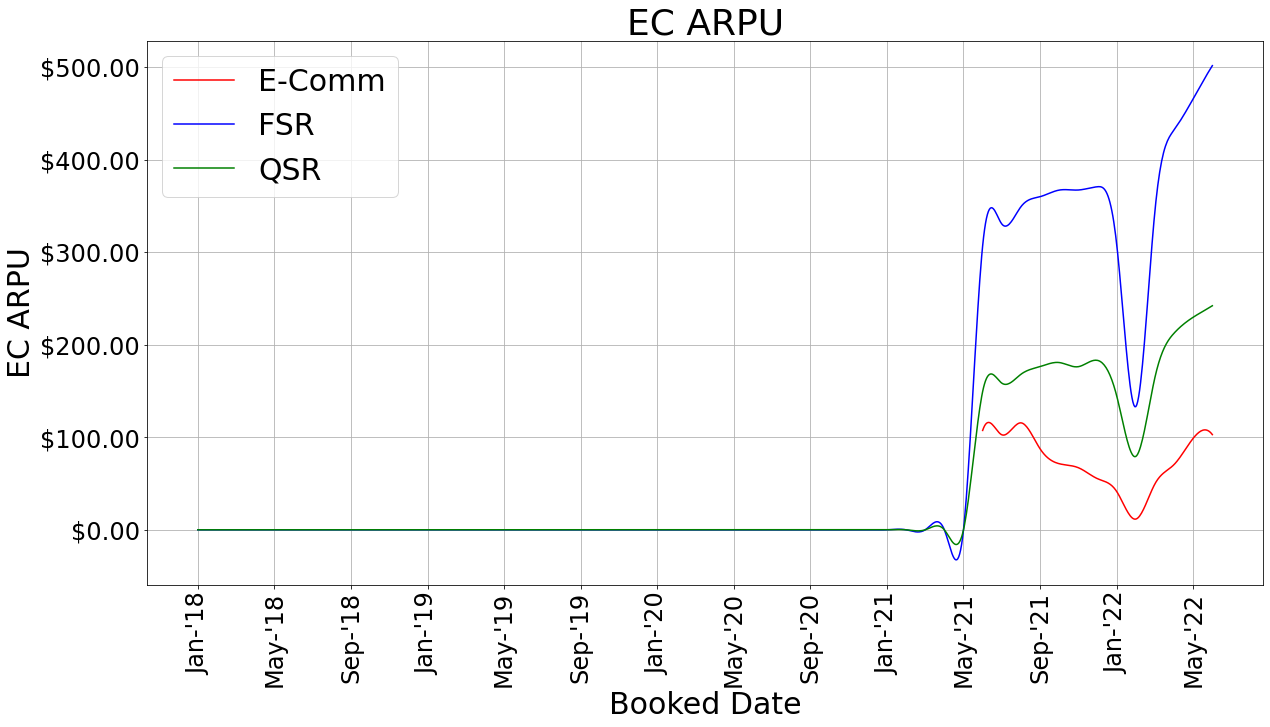

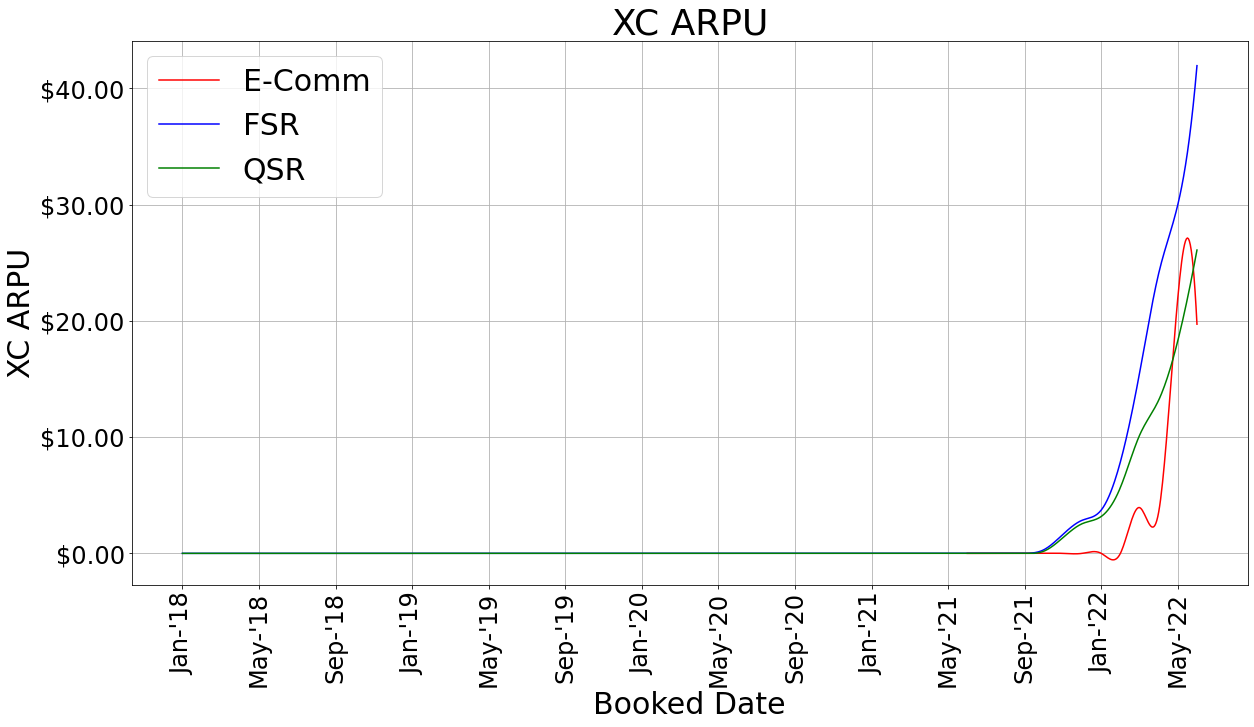

In [193]:
dateGroup = 'Month'
grouping = 'FSR/QSR/E-Comm'



tmp = monthlyCust[(monthlyCust['Last N Months'] >= 3)].groupby([dateGroup, grouping]).agg({'Customer Id': 'nunique', 'Live Payments ARR': 'sum','Live SaaS ARR':'sum', 'Guest SaaS ARR':'sum', 'Commerce SaaS ARR':'sum', 'EC SaaS ARR':'sum', 'XC SaaS ARR':'sum'}).reset_index().rename(columns = {'Customer Id': 'Locations'})
tmp['Payments ARPU'] = tmp['Live Payments ARR'] / tmp['Locations']
tmp['SaaS ARPU'] = tmp['Live SaaS ARR'] / tmp['Locations']
tmp['Guest ARPU'] = tmp['Guest SaaS ARR'] / tmp['Locations']
tmp['Commerce ARPU'] = tmp['Commerce SaaS ARR'] / tmp['Locations']
tmp['EC ARPU'] = tmp['EC SaaS ARR'] / tmp['Locations']
tmp['XC ARPU'] = tmp['XC SaaS ARR'] / tmp['Locations']
tmp = tmp[(tmp[dateGroup] >= date(2018,1,1)) & (tmp[dateGroup] < date(2022,7,1))]
tmp['Percent of Locations'] = np.round(100 * tmp['Locations'] / tmp.groupby([dateGroup])['Locations'].transform('sum'), 2)
tmp = tmp[tmp['Locations'] > 50]

for col in ['Payments ARPU','SaaS ARPU', 'Guest ARPU', 'Commerce ARPU', 'EC ARPU', 'XC ARPU']:
    # Booked SaaS ARPU
    xAxisParams = AxisParams(spacing = 4, rotation = 90, axisFormat = "%b-'%y", title='Booked Date', fontsize = 30)
    yAxisParams = AxisParams(axisFormat = "2$", title=col, fontsize = 30)
    linePlot = PlotParams(plotStyle = 'Line', grid=True, k=3)
    titleParams = TitleParams(title=col, fontsize=36)
    legend = LegendParams(show=True)
    fig, ax  = PlotSmoothLine(tmp, dateGroup,  [col], group=grouping,  
                      plotParams = linePlot,
                      xAxisParams = xAxisParams,
                      yAxisParams = yAxisParams,
                      titleParams = titleParams,
                      legendParams = legend,

                       smoothing = True, showPlot = True,
                       savefig =None, verbose=False)

# ARPU Potential

In [320]:
monthlyCust['GPV Tier'] = pd.cut(monthlyCust['Annualized GPV'],
                           bins = [0, 250000, 500000, 1E6, 3E6, 5E6,np.inf],
                           labels = ['< 250k', '250k - 500k', '500k - 1M', '1M - 3M', '3M - 5M','5M+'])

gpvTier = {'< 250k':0, 
             '250k - 500k':1, 
             '500k - 1M':2, 
             '1M - 3M':3, 
             '3M - 5M':4,
             '5M+':5}

monthlyCust['GPV Tier Ranking'] = monthlyCust['GPV Tier'].map(gpvTier)


In [371]:
monthlyCust['Margin BPS'] = monthlyCust['Margin'] / monthlyCust['GPV'] * 10000
monthlyCust['BPS Tier'] = pd.cut(monthlyCust['Margin BPS'],
                           bins = [-np.inf, 10, 30, 50, 75, 100,np.inf],
                           labels = ['< 10', '10 - 30', '30 - 50', '50 - 75', '75 - 100','100+'])

bpsTier = {'< 10':0, 
           '10 - 30':1, 
           '30 - 50':2, 
           '50 - 75':3, 
           '75 - 100':4,
           '100+':5}

monthlyCust['BPS Tier Ranking'] = monthlyCust['BPS Tier'].map(bpsTier)


In [374]:
monthlyCust['Full Type With E-Comm'] = np.where(monthlyCust['E-Comm'], 'E-Comm', monthlyCust['FSR/QSR'] + ' - ' + monthlyCust['Type'] )
currCust = monthlyCust[(monthlyCust['Month'] == date(2022,9,1))]

In [347]:
output = pd.DataFrame()

for fullType in currCust['Full Type With E-Comm'].unique().tolist():
    for gpvTier in currCust['GPV Tier'].unique().tolist():
        tmp = currCust[(currCust['Full Type With E-Comm'] == fullType) & (currCust['GPV Tier'] == gpvTier)]
        arpuTarget = np.round(tmp['Live ARR'].quantile(0.95),2)
        restCust = tmp[tmp['Live ARR'] < arpuTarget]
        medARPURest = restCust['Live ARR'].median()
        custInGroup = len(tmp)
        custInRest = len(tmp[tmp['Live ARR'] < arpuTarget])
        gpvTierRank = tmp['GPV Tier Ranking'].min()
        
        potentialARR = (arpuTarget - medARPURest) * custInRest * 0.25
        
        tmpDF = pd.DataFrame({'Type': [fullType], 'GPV Tier': [gpvTier], 'GPV Tier Ranking': [gpvTierRank],
                              'Num Locations': [custInGroup], 'Median ARPU Rest': [medARPURest],'Optimal ARPU': [arpuTarget], 
                              'Potential ARPU Impact': [potentialARR / len(currCust)], 'Potential ARR': [potentialARR]})
        output = pd.concat([output, tmpDF])
output = output[output['Num Locations'] > 100]
print(f"Total ARPU Current: {currCust['Live ARR'].mean()}")

Total ARPU Current: 11038.277154072419


In [378]:
print(f"Total ARPU Impact: ${np.round(output['Potential ARPU Impact'].sum(), 2)}")
output.sort_values(['Potential ARPU Impact'], ascending=False).head()

Total ARPU Impact: $2495.86


,Type,GPV Tier,GPV Tier Ranking,Num Locations,Median ARPU Rest,Optimal ARPU,Potential ARPU Impact,Potential ARR
0,FSR - FSR - Casual,1M - 3M,3.0,9391,13662.616342,28295.51,442.490625,3.263501e+07
0,FSR - FSR - Casual,3M - 5M,4.0,2599,18702.275298,42666.25,200.558125,1.479176e+07
0,FSR - FSR - Casual,5M+,5.0,1422,24671.448107,63202.38,176.320821,1.300419e+07
0,FSR - Bar/Lounge,1M - 3M,3.0,2766,13594.225563,28949.20,136.731787,1.008438e+07
0,FSR - FSR - Casual,500k - 1M,2.0,4172,9248.942701,17143.63,106.052112,7.821661e+06


In [380]:
tmp = currCust[(currCust['Full Type With E-Comm'] == 'FSR - FSR - Casual') & (currCust['GPV Tier'] == '1M - 3M')]
tmp['Locations'] = 1
topCust = tmp[tmp['Live ARR'] >= tmp['Live ARR'].quantile(0.95)]
restCust = tmp[tmp['Live ARR'] < tmp['Live ARR'].quantile(0.95)]

In [390]:
currCust[currCust['EC SaaS ARR'] > 0].sample()

,Customer Id,Month,MSA,Region,Segment,Type,FSR/QSR,E-Comm,Rep Id,Go-Live This Month,Close Date,FOD,Live ARR,Live Payments ARR,Live SaaS ARR,Guest SaaS ARR,Commerce SaaS ARR,EC SaaS ARR,XC SaaS ARR,GPV,Margin,GPV Tx,GPV Last N Months,Last N Months,Annualized GPV,GMV,GMV Tx,Module Count,EC,OO,GC,Loyalty,TTO,Marketing,TDS,OPT,DD,UE,GH,HH,Kiosk,KDS,API,MLM,Core,Close Month,Close Quarter,FOQ,FSR/QSR/E-Comm,Full Type With E-Comm,GPV Tier,GPV Tier Ranking,Margin BPS,BPS Tier,BPS Tier Ranking
953399,f882c4ee12a10c5da0282f610d1669c1,2022-09-01,"Portland-Vancouver-Beaverton, OR-WA MSA",West,SMB,Bar/Lounge,FSR,False,7ee0dea180c3f825cf490304096c7287,true,2022-02-28,2022-09-22,17904.23218,1596.23218,16308.0,2957.52,10835.16,727.32,1788.0,90109.69,399.058045,1497.0,0.0,0.0,0.0,94568.4,1616.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,5.0,0.0,0.0,5.0,2022-02-01,2022-01-01,2022-07-01,FSR,FSR - Bar/Lounge,NaN,NaN,44.285808,30 - 50,2


In [389]:
currCust[currCust['EC SaaS ARR'] > 0][['EC SaaS ARR']].describe()

,EC SaaS ARR
count,2705.000000
mean,887.562152
std,629.569334
min,0.030000
25%,509.124000
50%,696.600000
75%,840.000000
max,8082.960000


In [385]:
##########################################################
restTmp = restCust.groupby(['BPS Tier'])[['Locations']].sum()
restTmp['%'] = np.round(100 * restTmp['Locations'] / restTmp['Locations'].sum(),2)
display(restTmp)
##########################################################

topTmp = topCust.groupby(['BPS Tier'])[['Locations']].sum()
topTmp['%'] = np.round(100 * topTmp['Locations'] / topTmp['Locations'].sum(),2)
display(topTmp)

##########################################################
topTmp = topCust.groupby(['BPS Tier'])[['Locations']].sum()
topTmp['%'] = np.round(100 * topTmp['Locations'] / topTmp['Locations'].sum(),2)
display(topTmp)

,Locations,%
BPS Tier,,
< 10,484,5.47
10 - 30,2116,23.90
30 - 50,2535,28.63
50 - 75,2075,23.44
75 - 100,978,11.05
100+,665,7.51


,Locations,%
BPS Tier,,
< 10,0,0.00
10 - 30,1,0.21
30 - 50,18,3.84
50 - 75,57,12.15
75 - 100,128,27.29
100+,265,56.50
